# Redes Neurais Convolucionais

- using CIFAR-10 Dataset
- https://docs.pytorch.org/docs/stable/user_guide/index.html
- aprendizado supervisionado (com dados que possuem rótulos prévios)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import CIFAR10


In [2]:
DATA_DIR = '/content/sample_data/cifar10'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
cifar10_train = CIFAR10(DATA_DIR, train = True, download = True)
cifar10_test = CIFAR10(DATA_DIR, train = False, download = True)

100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


In [4]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [5]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

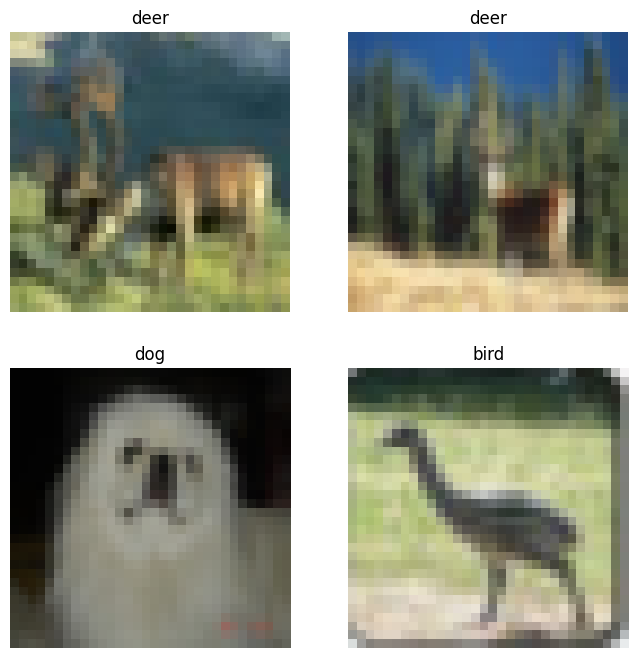

In [6]:
lookat_dataset(cifar10_train)

## Pré-processamento

In [7]:
# converter de img pra tensor
import torchvision.transforms as T


In [8]:
prep_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2470, 0.2435, 0.2616))
 ])

tensor_train = CIFAR10(DATA_DIR, train = True,
                       download = False, transform = prep_transform)
tensor_test = CIFAR10(DATA_DIR, train = False,
                      download = False, transform = prep_transform)

In [9]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape  # 3 canais de cor RBG, 32x32 comprimento e largura, 50000 samples

torch.Size([3, 32, 32, 50000])

In [10]:
imgs.view(3,-1).mean(dim=1) # RGB média - vermelho, verde, azul

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [11]:
imgs.view(3,-1).std(dim=1) # desvio padrao

tensor([1.0001, 0.9999, 1.0000])

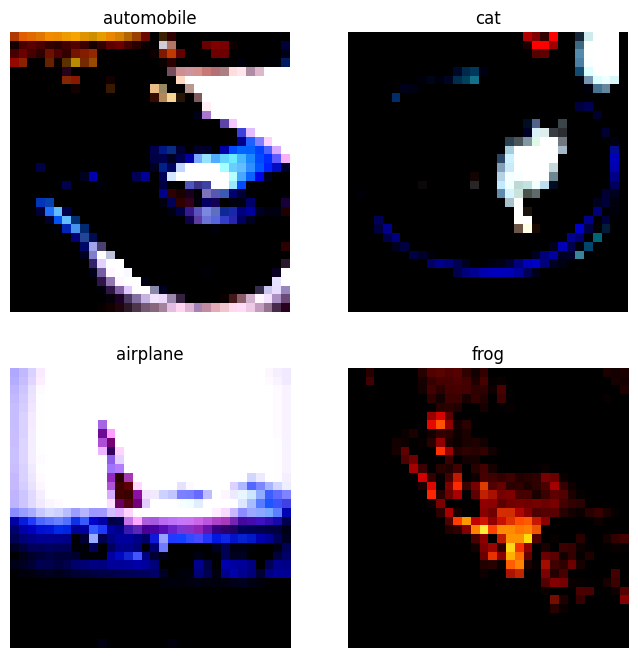

In [12]:
lookat_dataset(tensor_train, True)

## Criando Dataloaders

In [13]:
from torch.utils.data import DataLoader

In [14]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

## Construindo uma rede MLP
Multi-Level Perceptron

In [15]:
from torch import nn

In [16]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten() #planifica a imagem

    self.layers = nn.Sequential(
        nn.Linear(32*32*3, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),

    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")


Rodando na cuda


In [18]:
model = MLPClassifier().to(device)


## Escolhendo Hiperparâmetros

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [21]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)


In [22]:
# Aprenda sobre Matplotlib com a Kizzy: https://youtu.be/iSpi3rKdoLQ
# Introdução ao Matplotlib | Gráficos em Python | Análise de dados #7
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");


In [23]:
epochs = 31
train_losses = []
test_losses = []

for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)

  if t % 10 == 0:
    print("")

  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

In [ ]:
# cada pixel está sendo representado como uma característica da img
# esse modelo (Multi Layer Perceptron) falha em representar a coerencia espacial
#

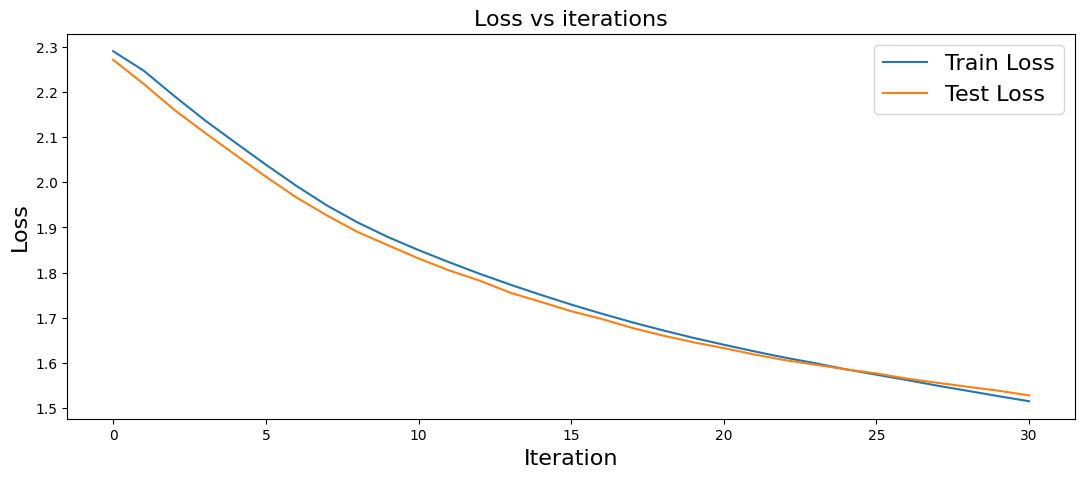

In [24]:
losses = {"Train Loss": train_losses, "Test Loss": test_losses}
plot_losses(losses)

## Avaliando o resultado


In [25]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [26]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)


Accuracy for class airplane is: 50.8 %
Accuracy for class automobile is: 59.8 %
Accuracy for class bird  is: 27.5 %
Accuracy for class cat   is: 37.1 %
Accuracy for class deer  is: 32.2 %
Accuracy for class dog   is: 33.1 %
Accuracy for class frog  is: 53.8 %
Accuracy for class horse is: 52.8 %
Accuracy for class ship  is: 65.0 %
Accuracy for class truck is: 50.7 %
Global acccuracy is 46.3


<Axes: >

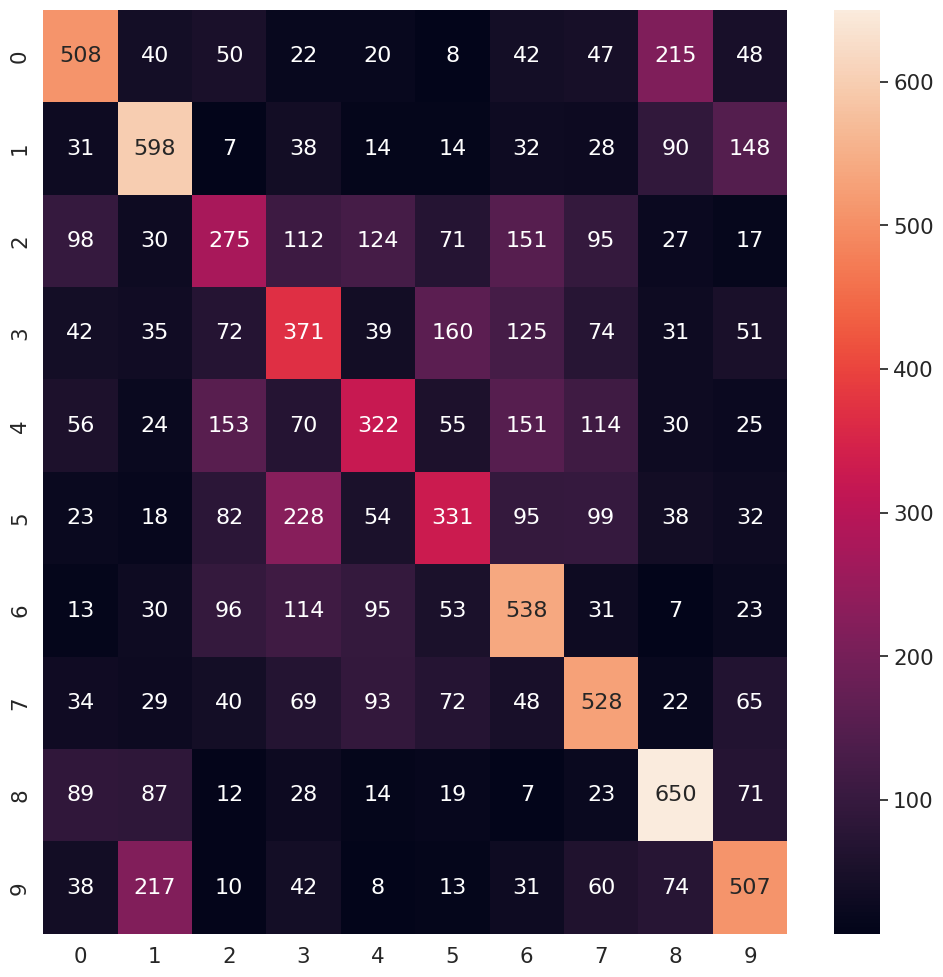

In [27]:
import seaborn as sn

plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')


## Construindo uma rede neural de convolução


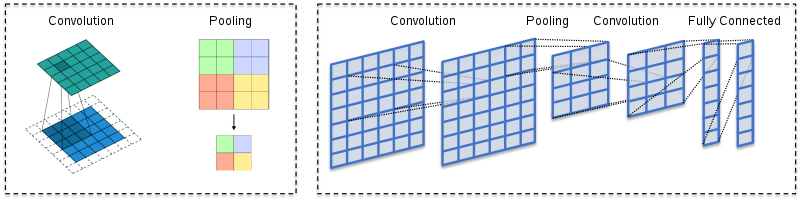

In [43]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.convlayers = nn.Sequential(
        # 3 mapas canais rgb, gerando 16 mapas
        # | padding olhando pra fora, padrao 0
        # | stride = quanto vai andar por unidade
        nn.Conv2d(3, 16, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # camada de pooling

        nn.Conv2d(16, 32, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )

    self.linearlayers = nn.Sequential(
        nn.Linear(1152, 256), # conta desgraçada, da pra treinar na cpu e o erro mostra a dimensao
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    # aprende as features
    x = self.convlayers(x)
    x = torch.flatten(x,1)
    return self.linearlayers(x)


In [40]:
convmodel = ConvolutionalModel().to(device)

In [45]:
conv_optimizer = torch.optim.SGD(convmodel.parameters(), lr=0.001)
convlossfunc = nn.CrossEntropyLoss()

In [46]:
epochs = 31
train_losses = []
test_losses = []

for t in range(epochs):
  train_loss = train(convmodel, train_loader, convlossfunc, conv_optimizer)
  train_losses.append(train_loss)

  if t % 10 == 0:
    print("")

  test_loss = validate(convmodel, test_loader, convlossfunc)
  test_losses.append(test_loss)

### Avaliando

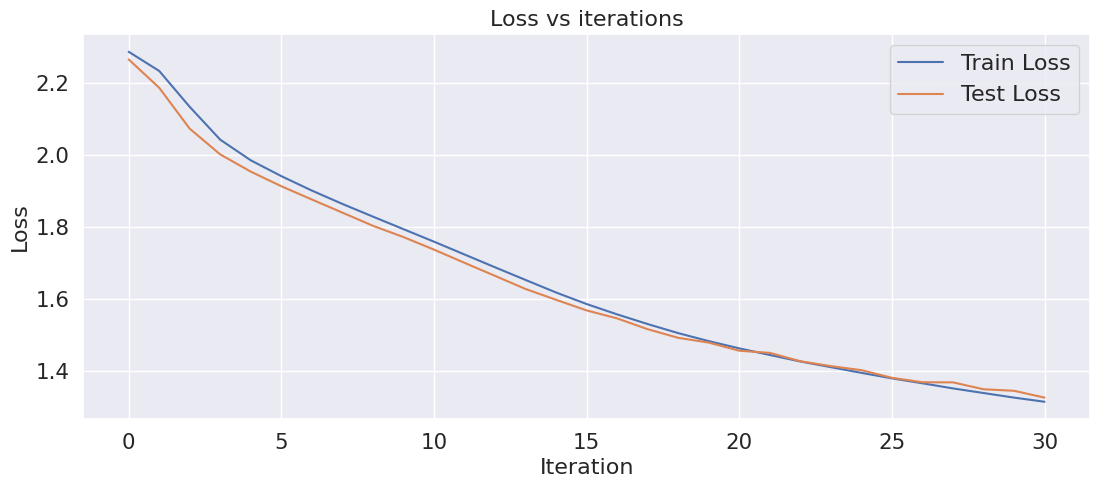

In [47]:
conv_losses = {"Train Loss": train_losses, "Test Loss": test_losses}
plot_losses(conv_losses)

In [48]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is: 53.0 %
Accuracy for class automobile is: 63.0 %
Accuracy for class bird  is: 39.0 %
Accuracy for class cat   is: 24.8 %
Accuracy for class deer  is: 38.9 %
Accuracy for class dog   is: 51.0 %
Accuracy for class frog  is: 61.5 %
Accuracy for class horse is: 61.2 %
Accuracy for class ship  is: 71.2 %
Accuracy for class truck is: 65.4 %
Global acccuracy is 52.9


### Testando em Exemplos Práticos

In [49]:
from PIL import Image

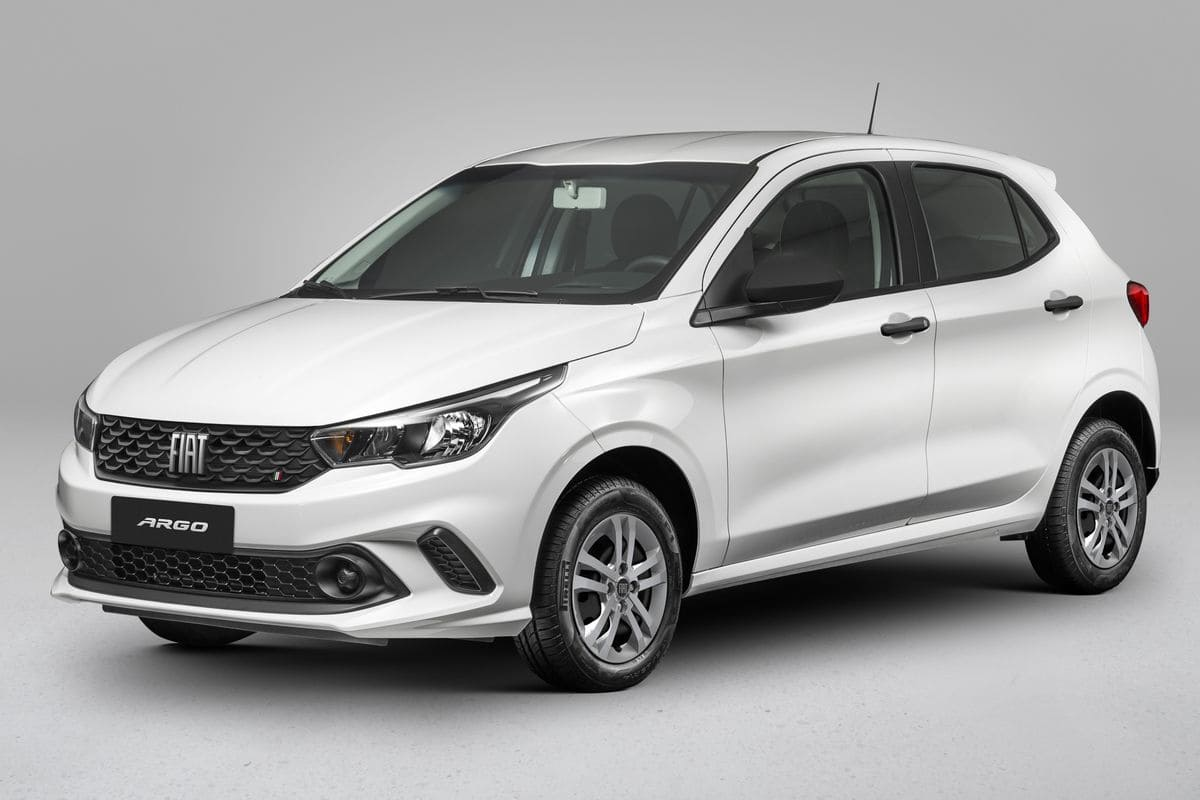

In [52]:
img = Image.open('/content/sample_data/carro.png')
img

In [56]:
prep_transforms = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
img_tensor = prep_transforms(img)

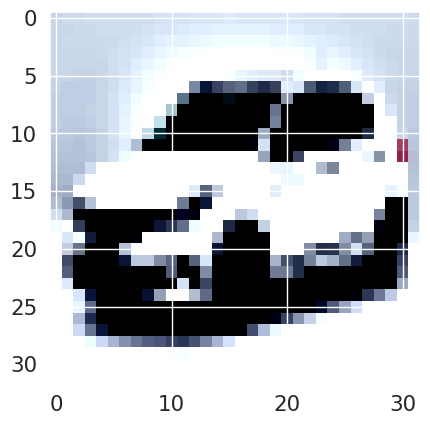

In [57]:
plt.imshow(img_tensor.permute(1,2, 0))

In [59]:
batch = img_tensor.unsqueeze(0).to(device) # [2] -> [[2]]

In [60]:
convmodel.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [61]:
output = convmodel(batch)
output

tensor([[ 2.7554,  6.9480, -2.4580, -2.3029, -3.0014, -3.9218, -2.6994, -2.9408,
          2.2806,  4.5504]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [62]:
probs = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
  prob = probs[0][i].item()
  print(f"{classname} probability: {prob:.2f}")
  prob_dict[classname] = [prob]

airplane probability: 1.35
automobile probability: 89.62
bird probability: 0.01
cat probability: 0.01
deer probability: 0.00
dog probability: 0.00
frog probability: 0.01
horse probability: 0.00
ship probability: 0.84
truck probability: 8.15


<Axes: >

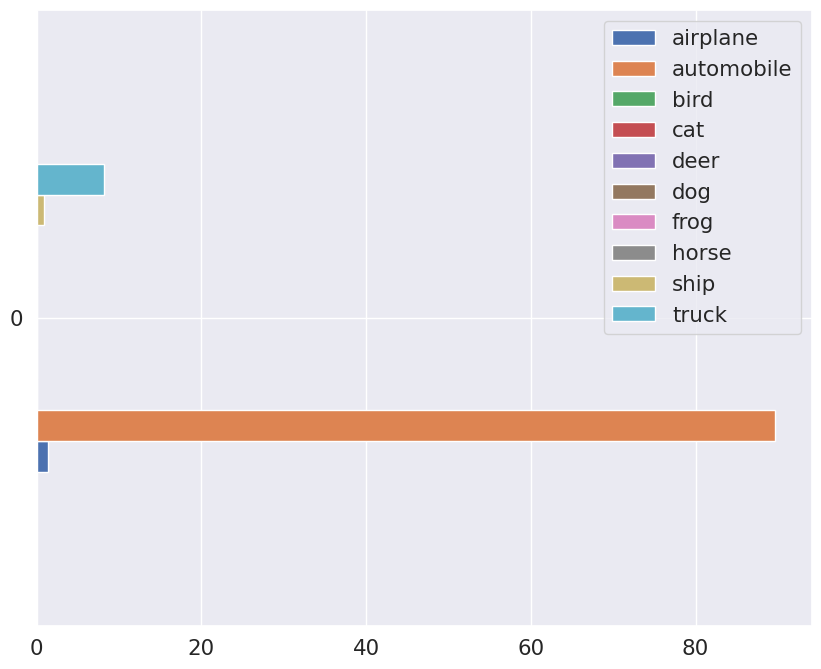

In [66]:
import pandas as pd

df_prob = pd.DataFrame.from_dict(prob_dict)
df_prob.plot(kind='barh', figsize=(10,8))